In [31]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from surya.foundation import FoundationPredictor
from surya.recognition import RecognitionPredictor
from surya.detection import DetectionPredictor
import torch
from pdf2image import convert_from_path
import os
import io
import gc
from PIL import Image

In [32]:
!pip install pdf2image 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [33]:
from surya.foundation import FoundationPredictor
from surya.recognition import RecognitionPredictor
from surya.detection import DetectionPredictor
import torch
import torch
import os
from tqdm import tqdm
import numpy as np
import  cv2
device = "mps" if torch.backends.mps.is_available() else "cpu"
def pdf_to_images(path, dpi=300):
    images = []
    if os.path.isfile(path):
        images.extend(convert_from_path(path, dpi=dpi))
    else:
        for pdf_file in tqdm(os.listdir(path), desc="Converting PDFs"):
            if pdf_file.lower().endswith('.pdf'):
                pdf_path = os.path.join(path, pdf_file)
                images.extend(convert_from_path(pdf_path, dpi=dpi))
    print(f"\n‚úÖ Conversion complete!")
    return images

pages = pdf_to_images("/Users/maryamsaad/Documents/grad_data/fast_test.pdf")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



‚úÖ Conversion complete!


In [36]:
len(pages)

4

Detecting bboxes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  2.09it/s]



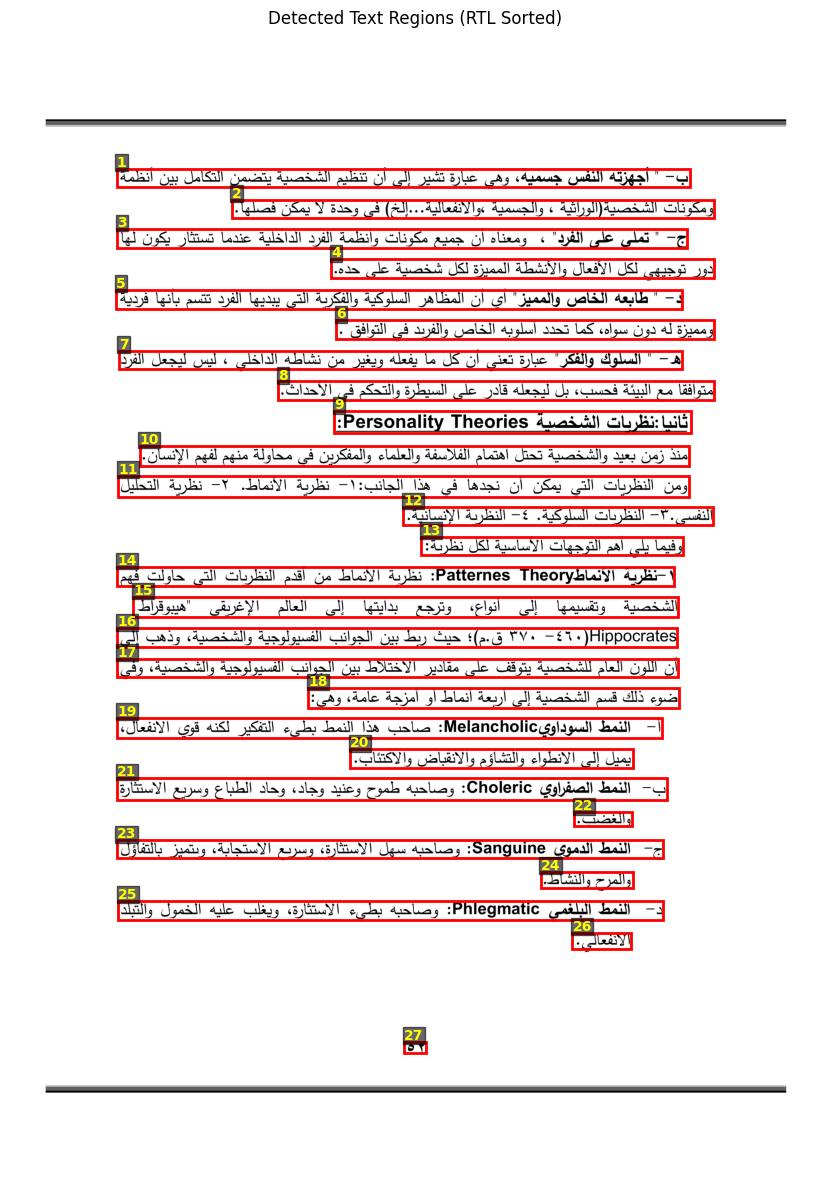

Detecting bboxes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  2.13it/s]]



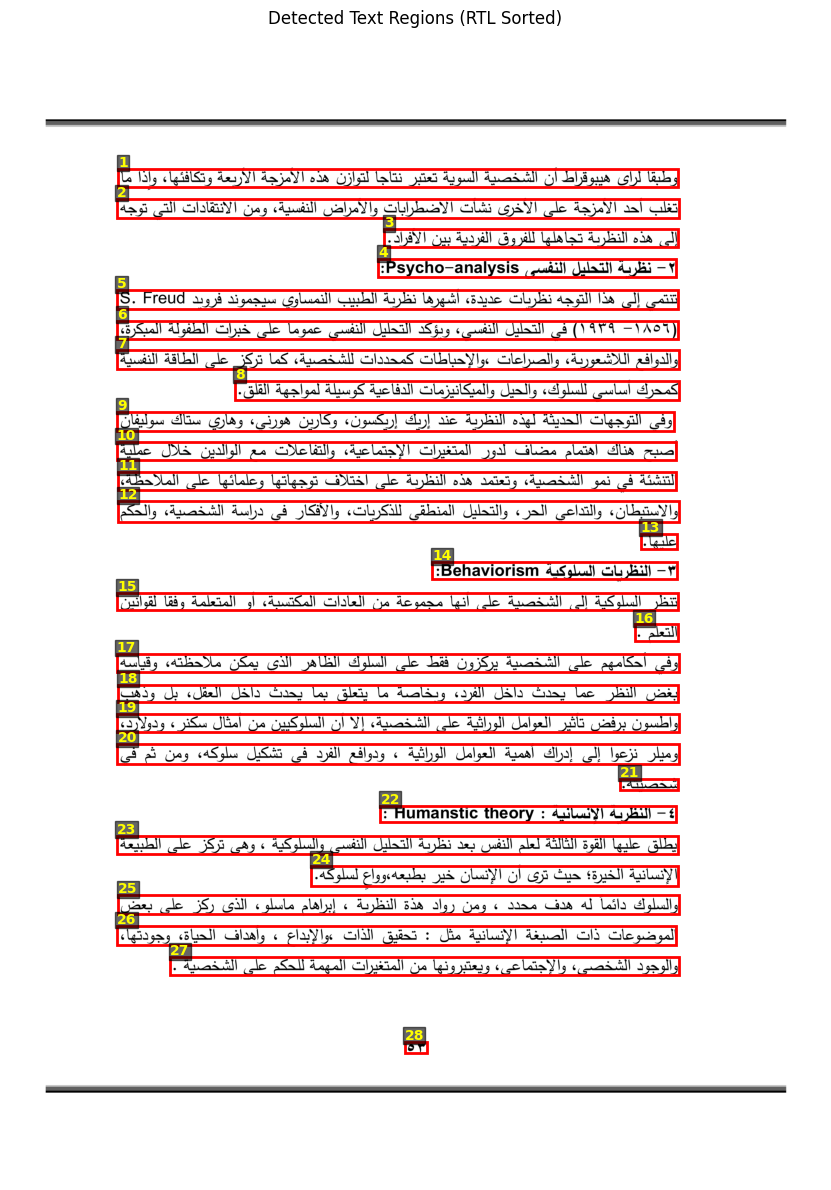

Detecting bboxes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  2.14it/s]]



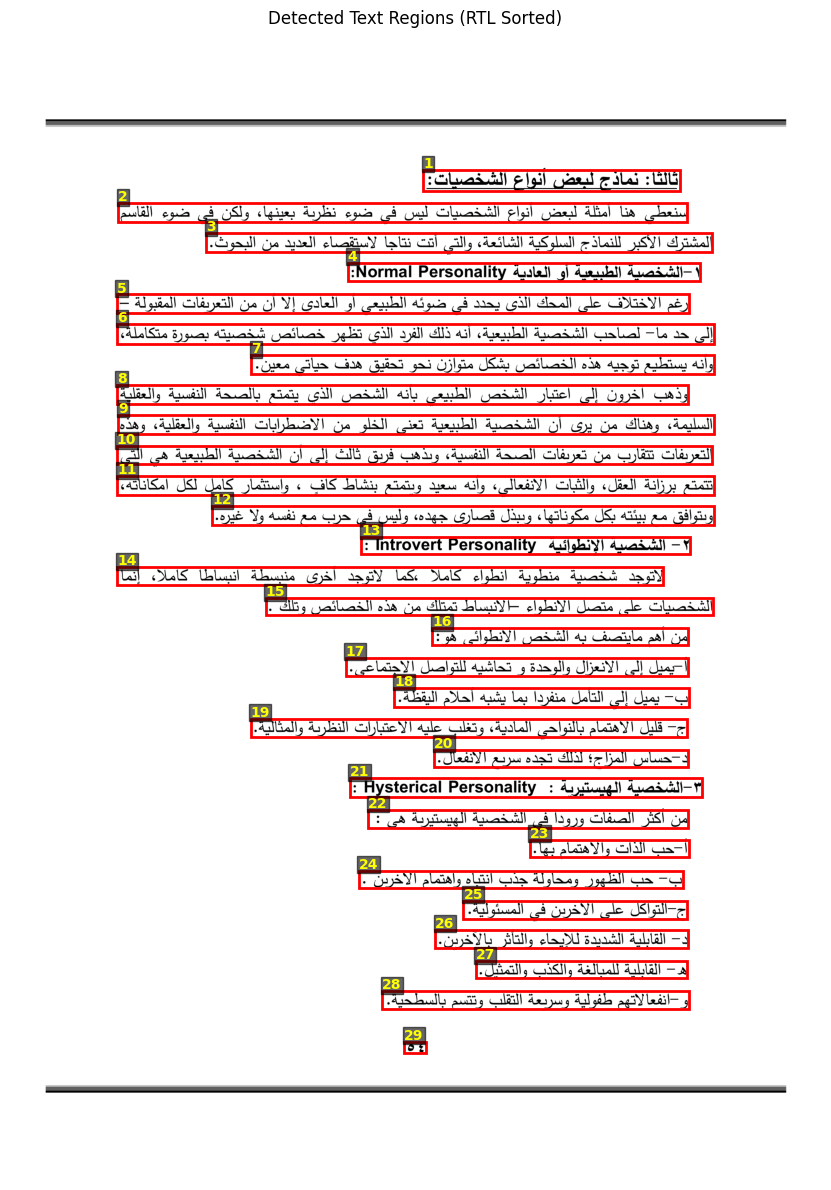

Detecting bboxes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  2.18it/s]]



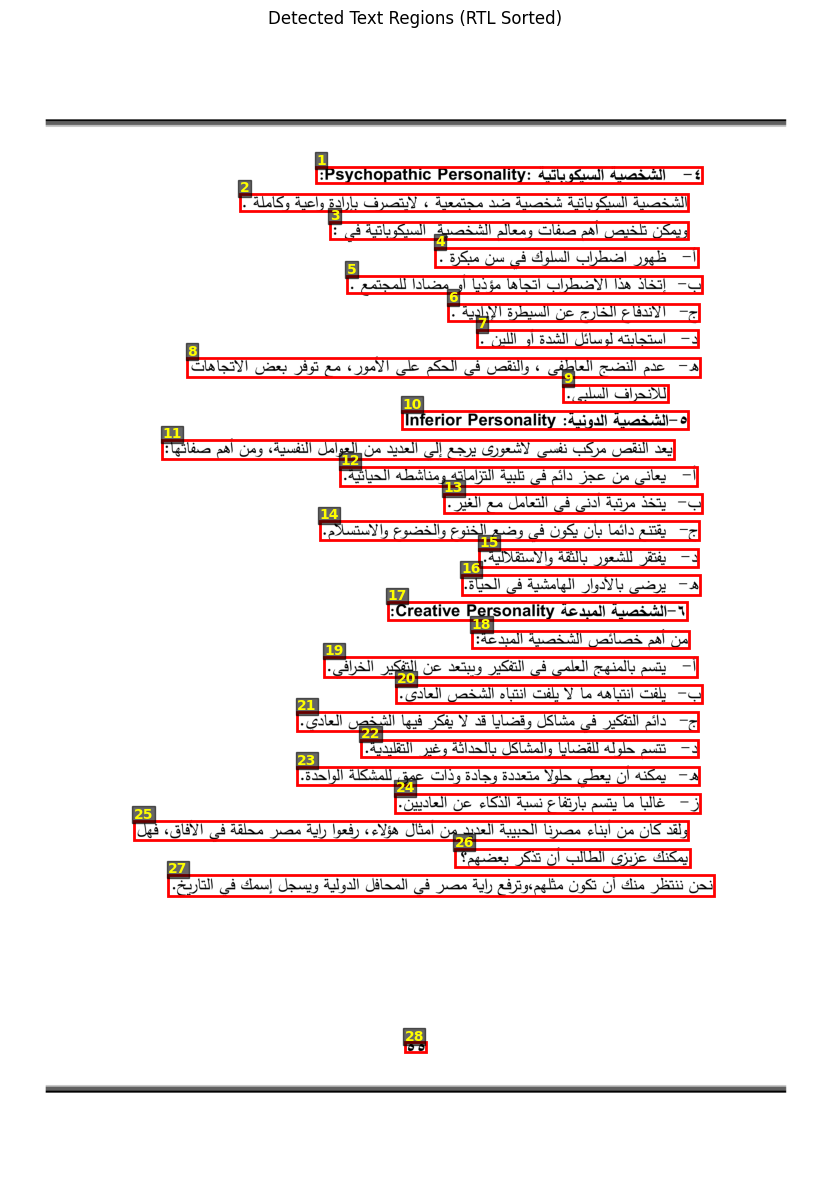

Processing Images: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.41it/s]


In [38]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- Helper: Sort boxes for Arabic reading order (top‚Üíbottom, right‚Üíleft) ---
def sort_bboxes_rtl(bboxes, y_threshold=20):
    """
    Sort bounding boxes top-to-bottom and right-to-left within each line.
    This helps visualize text in Arabic order for OCR or debugging.
    """
    if not bboxes:
        return []
    
    # Extract [x1, y1, x2, y2]
    boxes = [[b.bbox[0], b.bbox[1], b.bbox[2], b.bbox[3]] for b in bboxes]
    
    # Sort by top Y coordinate (line order)
    boxes = sorted(boxes, key=lambda b: b[1])

    # Group boxes into lines (based on vertical proximity)
    lines = []
    current_line = [boxes[0]]
    for b in boxes[1:]:
        if abs(b[1] - current_line[-1][1]) < y_threshold:
            current_line.append(b)
        else:
            lines.append(current_line)
            current_line = [b]
    lines.append(current_line)

    # Sort each line right-to-left
    sorted_boxes = []
    for line in lines:
        line_sorted = sorted(line, key=lambda b: b[0], reverse=True)
        sorted_boxes.extend(line_sorted)
    
    return sorted_boxes


# --- Detection + Visualization ---
foundation_predictor = FoundationPredictor()
recognition_predictor = RecognitionPredictor(foundation_predictor)
detection_predictor = DetectionPredictor(device=device)

CONF_THRESHOLD = 0.65

for image in tqdm(pages, desc="Processing Images"):
    detection_results = detection_predictor([image])
    det_result = detection_results[0]

    # Filter by confidence
    filtered_boxes = [b for b in det_result.bboxes if b.confidence >= CONF_THRESHOLD]

    # Sort RTL
    sorted_boxes = sort_bboxes_rtl(filtered_boxes)

    # --- Plot with bounding boxes ---
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(image)

    for i, (x1, y1, x2, y2) in enumerate(sorted_boxes, start=1):
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x1, y1 - 6, f"{i}",
            color="yellow",
            fontsize=10,
            fontweight="bold",
            bbox=dict(facecolor="black", alpha=0.6, pad=1)
        )

    plt.title("Detected Text Regions (RTL Sorted)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


## initlizing ocr

In [39]:
import torch
from transformers import AutoProcessor,Qwen2VLForConditionalGeneration
from PIL import Image
from pdf2image import convert_from_path
from PIL import Image
import os
from tqdm import tqdm
import json
from jiwer import wer, cer, process_words
import re

In [40]:

model_id = "NAMAA-Space/Qari-OCR-v0.3-VL-2B-Instruct"
processor_id = "Qwen/Qwen2-VL-2B-Instruct"

# Use CPU for now (MPS has memory issues with large vision models)
device = torch.device("mps")
print(device)

# Load model with float32 for CPU
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16, 
    trust_remote_code=True,
    cache_dir="./Qari_model_cache"
).to(device)

# Load processor
processor = AutoProcessor.from_pretrained(
    processor_id,
    trust_remote_code=True,
    cache_dir="./Qwen_processor_cache"
)

print(f"‚úÖ Model ready on {device}")


mps
‚úÖ Model ready on mps
‚úÖ Model ready on mps


In [41]:
def get_ocr_prompt() -> str:
    """Get the OCR instruction prompt for Arabic text."""
    return """
        You are an Arabic OCR specialist designed to extract text from images containing Arabic content. When processing images:
        1. ALWAYS read Arabic text from right to left, and top to bottom.
        3. DO NOT hallucinate text when encountering:
           - Decorative elements
           - Page numbers, stamps, or margin notes
           - Blurry or unclear text
        4. When text is unclear, mark it as [ÿ∫Ÿäÿ± Ÿàÿßÿ∂ÿ≠].
        5. Only transcribe visible text ‚Äî accuracy > completeness.
        6. Ignore watermarks and non-text background elements.
        8. Preserve original formatting, including line breaks and spacing.
        9. Do not hallucinate punctuation or diacritics. 
        10. Output the extracted text as it is visually presented in the image.
        Return the extracted text only.
    """


In [42]:
def extract_text_from_image(images, model, processor, max_size=(1024, 1024)):
    ocr_results = []

    for img in tqdm(images, desc="Extracting text"):
        # Resize image if too large
        if img.size[0] > max_size[0] or img.size[1] > max_size[1]:
            img.thumbnail(max_size, Image.Resampling.LANCZOS)
        
        prompt_messages = [
            {"role": "system", "content": get_ocr_prompt()},
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": img},
                    {"type": "text", "text": "Extract text from the provided image accurately."}
                ]
            }
        ]
        # Apply chat template
        prompt_text = processor.apply_chat_template(
            prompt_messages,
            add_generation_prompt=True,
            tokenize=False
        )

        # Tokenize with image input
        inputs = processor(
            text=prompt_text,
            images=img,
            return_tensors="pt",
            padding=True
        ).to(model.device)

        # Run inference with valid parameters only
        with torch.inference_mode():
            generated_ids = model.generate(
                **inputs,
                max_new_tokens=1500,
                do_sample=False, 
                repetition_penalty=1.4,
                # pad_token_id=processor.tokenizer.eos_token_id
            )
        

        generated_text = processor.batch_decode(
            generated_ids, 
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False
        )[0]
        ocr_results.append(generated_text.strip())

    return ocr_results

## preparing text boxes to ocr

In [44]:
sorted_boxes

[[936, 410, 2114, 459],
 [702, 495, 2073, 546],
 [977, 579, 2072, 632],
 [1299, 659, 2102, 718],
 [1029, 744, 2114, 797],
 [1339, 829, 2105, 883],
 [1428, 911, 2103, 961],
 [541, 994, 2108, 1052],
 [1691, 1078, 2010, 1130],
 [1199, 1156, 2071, 1213],
 [465, 1247, 2029, 1303],
 [1010, 1329, 2099, 1386],
 [1326, 1412, 2114, 1470],
 [946, 1495, 2105, 1552],
 [1434, 1579, 2103, 1634],
 [1380, 1660, 2110, 1721],
 [1154, 1741, 2069, 1797],
 [1411, 1829, 2077, 1883],
 [960, 1909, 2100, 1971],
 [1181, 1995, 2114, 2051],
 [878, 2078, 2103, 2135],
 [1072, 2163, 2103, 2216],
 [878, 2245, 2105, 2302],
 [1178, 2329, 2110, 2385],
 [378, 2410, 2074, 2468],
 [1359, 2495, 2079, 2551],
 [483, 2577, 2151, 2639],
 [1206, 3088, 1271, 3116]]

Detecting bboxes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  1.65it/s]



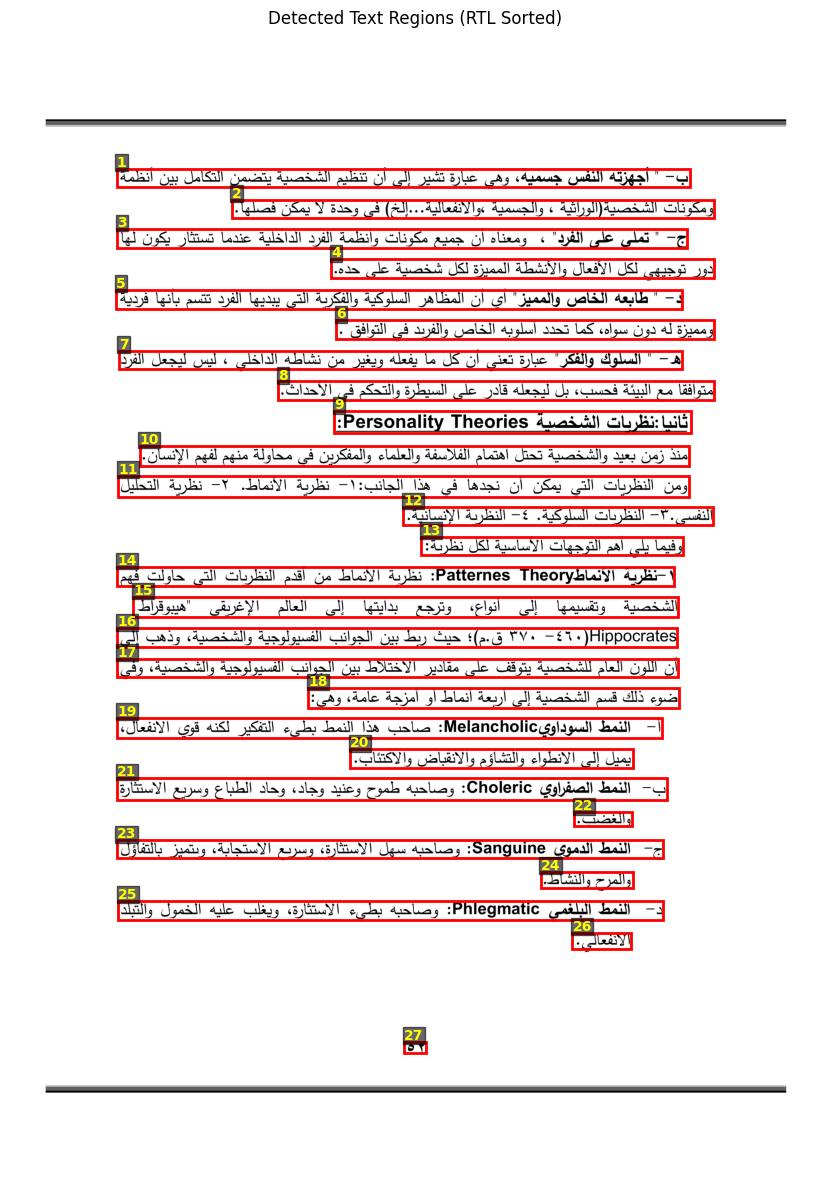

Detecting bboxes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  1.97it/s]]



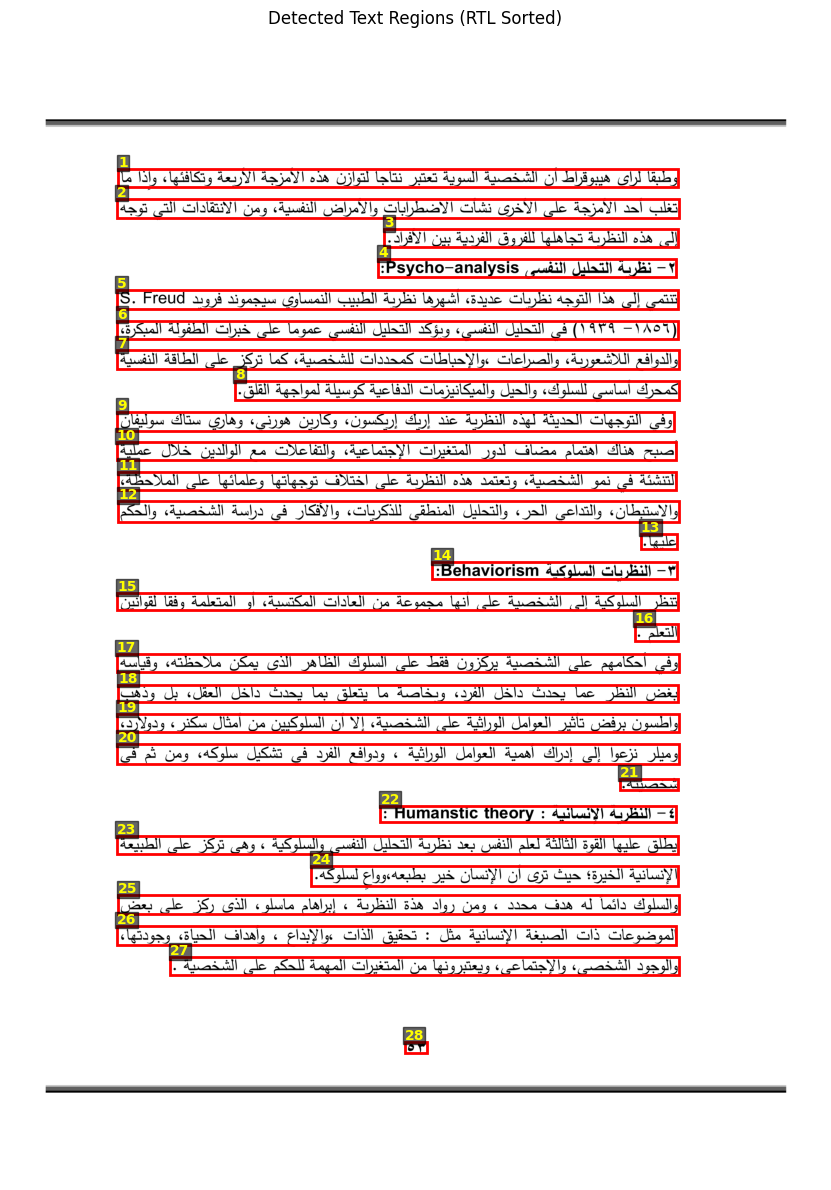

Detecting bboxes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  2.18it/s]]



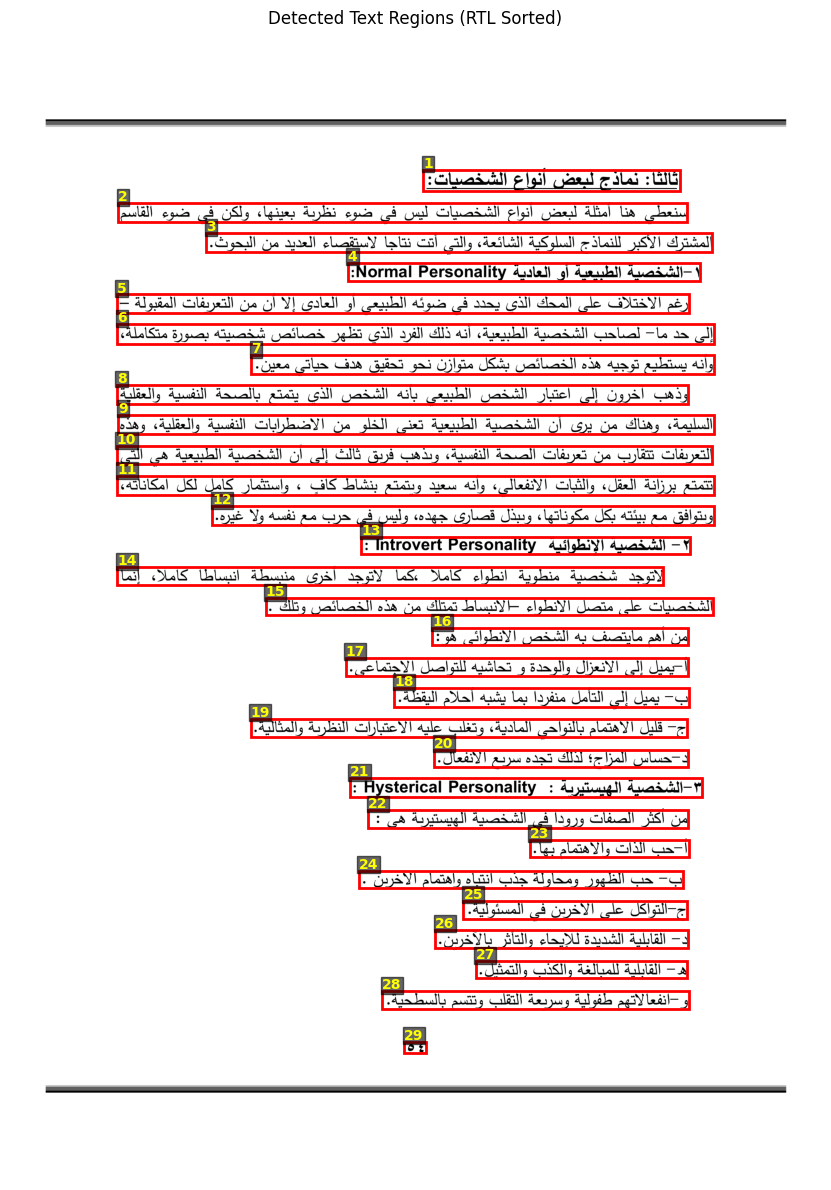

Detecting bboxes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  2.24it/s]]



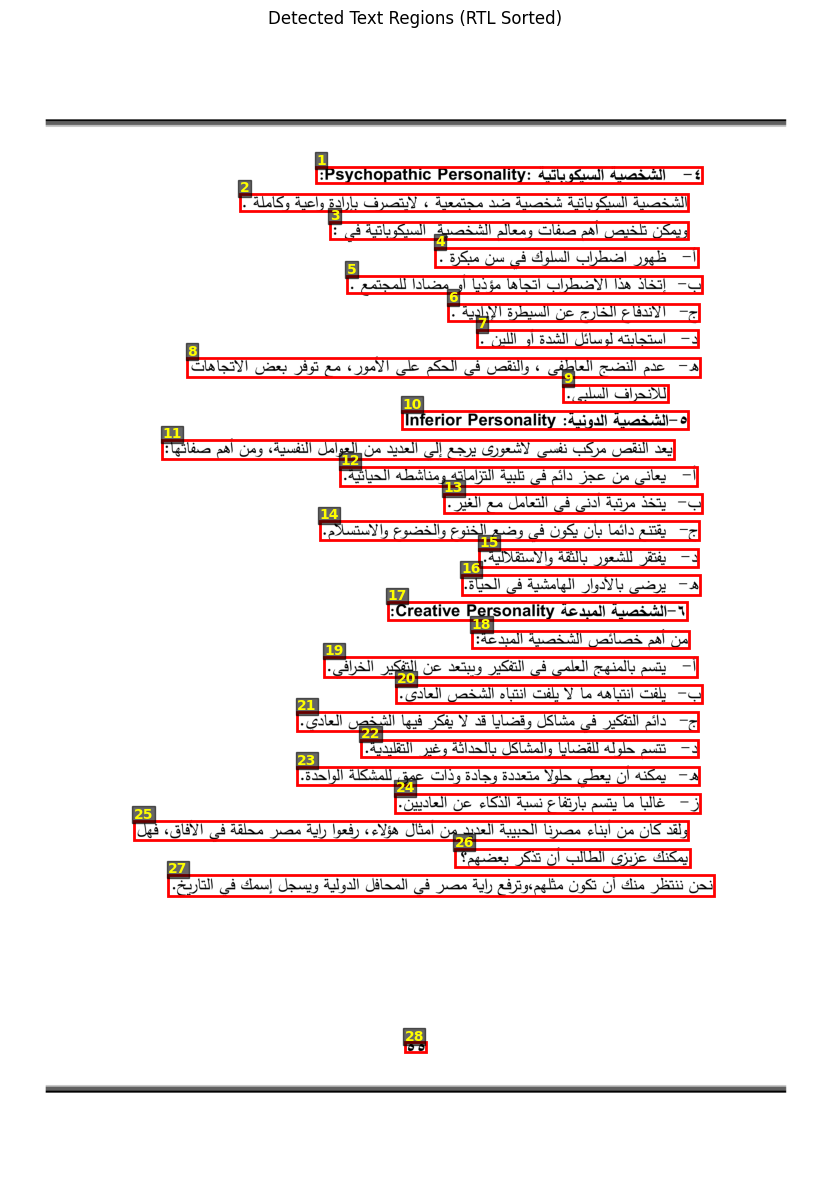

Processing Images: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:03<00:00,  1.31it/s]


In [45]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- Helper: Sort boxes for Arabic reading order (top‚Üíbottom, right‚Üíleft) ---
def sort_bboxes_rtl(bboxes, y_threshold=20):
    """
    Sort bounding boxes top-to-bottom and right-to-left within each line.
    This helps visualize text in Arabic order for OCR or debugging.
    """
    if not bboxes:
        return []
    
    # Extract [x1, y1, x2, y2]
    boxes = [[b.bbox[0], b.bbox[1], b.bbox[2], b.bbox[3]] for b in bboxes]
    
    # Sort by top Y coordinate (line order)
    boxes = sorted(boxes, key=lambda b: b[1])

    # Group boxes into lines (based on vertical proximity)
    lines = []
    current_line = [boxes[0]]
    for b in boxes[1:]:
        if abs(b[1] - current_line[-1][1]) < y_threshold:
            current_line.append(b)
        else:
            lines.append(current_line)
            current_line = [b]
    lines.append(current_line)

    # Sort each line right-to-left
    sorted_boxes = []
    for line in lines:
        line_sorted = sorted(line, key=lambda b: b[0], reverse=True)
        sorted_boxes.extend(line_sorted)
    
    return sorted_boxes


# --- Detection + Visualization ---
foundation_predictor = FoundationPredictor()
recognition_predictor = RecognitionPredictor(foundation_predictor)
detection_predictor = DetectionPredictor(device=device)

CONF_THRESHOLD = 0.65

for image in tqdm(pages, desc="Processing Images"):
    detection_results = detection_predictor([image])
    det_result = detection_results[0]

    # Filter by confidence
    filtered_boxes = [b for b in det_result.bboxes if b.confidence >= CONF_THRESHOLD]

    # Sort RTL
    sorted_boxes = sort_bboxes_rtl(filtered_boxes)

    # --- Plot with bounding boxes ---
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(image)

    for i, (x1, y1, x2, y2) in enumerate(sorted_boxes, start=1):
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x1, y1 - 6, f"{i}",
            color="yellow",
            fontsize=10,
            fontweight="bold",
            bbox=dict(facecolor="black", alpha=0.6, pad=1)
        )

    plt.title("Detected Text Regions (RTL Sorted)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [48]:
pages=pages[:1]

Extracting text: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27/27 [00:49<00:00,  1.82s/it]



üü® Box 1: "ÿ®- <i>"</b> ÿ£ÿ¨Ÿáÿ≤ÿ™Ÿá ÿßŸÑŸÜŸÅÿ≥ ÿ¨ÿ≥ŸÖŸäÿ©ÿå ŸàŸáŸä ÿπŸäÿßÿ±ÿ© ÿ™ÿ¥Ÿäÿ± ÿ•ŸÑŸâ ÿ£ŸÜ ÿ™ŸÜÿ∏ŸäŸÖ ÿßŸÑÿ¥ÿÆÿµŸäÿ© Ÿäÿ™ÿ∂ŸÖŸÜ ÿßŸÑÿ™ŸÉÿßŸÖŸÑ ÿ®ŸäŸÜ ÿßŸÜÿ∏ŸÖÿ™Ÿáÿß."
üü® Box 2: ŸÖŸÉŸàŸÜÿßÿ™ ÿßŸÑÿ¥ÿÆÿµŸäÿ© (ÿßŸÑŸàÿ±ÿßÿ´Ÿäÿ© ÿå ŸàÿßŸÑÿ¨ÿ≥ŸÖŸäÿ© <b>ÿåŸàÿßŸÑÿ•ŸÜŸÅÿπÿßŸÑÿßŸÑŸäÿ©</b><i>.</i>) ŸÅŸä Ÿàÿ≠ÿØÿ© ŸÑÿß ŸäŸÖŸÉŸÜ ŸÅÿµŸÑŸáÿß...ÿ•ŸÑÿÆ) ŸÅŸâ .
üü® Box 3: "ÿ¨Ÿá- " ÿ™ŸÖŸÑÿ¶Ÿä ÿπŸÑŸâ ÿßŸÑŸÅÿ±ÿØ"ÿå ŸàŸÖÿπŸÜÿßŸá ÿ£ŸÜ ÿ¨ŸÖŸäÿπ ŸÖŸÉŸàŸÜÿßÿ™ Ÿàÿ£ŸÜÿ∏ŸÖÿ© <b>ÿßŸÑŸÅÿ±ÿØ</b> ÿßŸÑÿØÿßÿÆŸÑŸäÿ© ÿπŸÜÿØŸÖÿß ÿ≥ÿ™ÿ´ÿßÿ±ÿ© ŸäŸÉŸàŸÜ ŸÑŸáÿßŸáÿß"
üü® Box 4: ÿØŸàÿ± ÿ™Ÿàÿ¨ŸäŸáŸä ŸÑŸÉŸÑ ÿßŸÑÿ£ŸÅÿπÿßŸÑ ŸàÿßŸÑÿ£ŸÜÿ¥ÿ∑ÿ© ÿßŸÑŸÖŸÖŸäÿ≤ÿ© <b>ŸÑŸÉŸÑ</b> ÿ¥ÿÆÿµŸäÿ© ÿπŸÑŸâ ÿ≠ÿØŸá..
üü® Box 5: - "ÿ∑ÿßŸÑÿ®Ÿá ÿßŸÑÿÆÿßÿµ ŸàÿßŸÑŸÖŸÖŸäÿ≤" ÿ£Ÿä ÿ£ŸÜ ÿßŸÑŸÖÿ∏ÿßŸáÿ± ÿßŸÑÿ≥ŸÑŸàŸÉŸäÿ© ŸàÿßŸÑŸÅŸÉÿ±Ÿäÿ© ÿßŸÑÿ™Ÿä Ÿäÿ®ÿØŸäŸáÿß ÿßŸÑŸÅÿ±ÿØ ÿ™ÿ™ÿ≥ŸÖ ÿ®ÿ£ŸÜŸëŸáÿß ŸÅÿ±ÿØŸäÿ© <b>‚Äì</b>
üü® Box 6: Ÿàÿ™ŸÖŸäÿ≤ÿ© ŸÑŸá ÿØŸàŸÜ ÿ≥ŸàÿßŸáÿå ŸÉŸÖÿß ÿ™ÿ≠ÿØÿØ ÿ£ÿ≥ŸÑŸàÿ®ÿ™Ÿá ÿßŸÑÿÆÿßÿµ ŸàÿßŸÑŸÅÿ±ŸäÿØ ŸÅŸä ÿßŸÑÿ™ŸàÿßŸÅŸÇ . <b>.</b></p><b

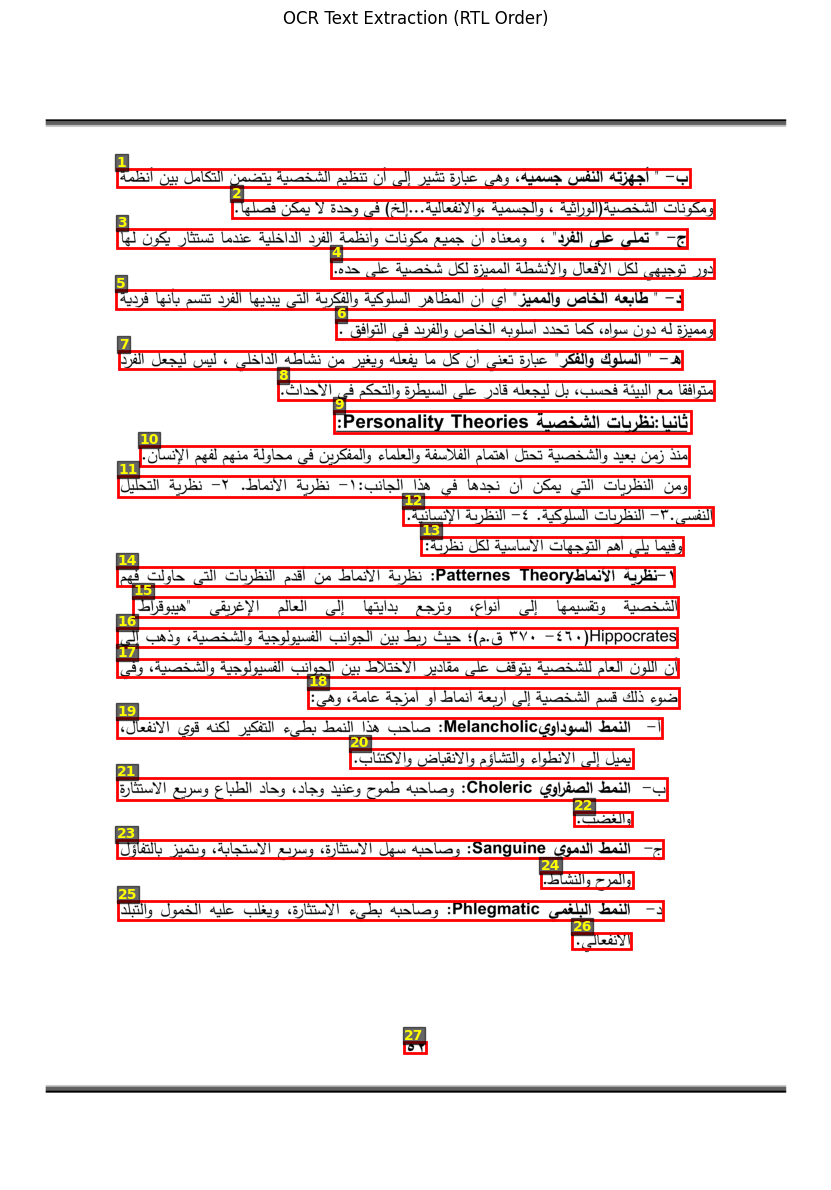

Processing Images: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:51<00:00, 51.09s/it]


In [50]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# --- Helper: RTL sorting function ---
def sort_bboxes_rtl(bboxes, y_threshold=20):
    """
    Sort bounding boxes top-to-bottom, right-to-left within each line.
    Ideal for Arabic text reading order.
    """
    if not bboxes:
        return []
    
    boxes = [[b.bbox[0], b.bbox[1], b.bbox[2], b.bbox[3], b.confidence] for b in bboxes]
    boxes = sorted(boxes, key=lambda b: b[1])  # sort top-to-bottom by y1

    lines = []
    current_line = [boxes[0]]
    for b in boxes[1:]:
        if abs(b[1] - current_line[-1][1]) < y_threshold:
            current_line.append(b)
        else:
            lines.append(current_line)
            current_line = [b]
    lines.append(current_line)

    # Sort each line right-to-left
    sorted_boxes = []
    for line in lines:
        line_sorted = sorted(line, key=lambda b: b[0], reverse=True)
        sorted_boxes.extend(line_sorted)
    
    return sorted_boxes


# --- Initialize models ---
foundation_predictor = FoundationPredictor()
recognition_predictor = RecognitionPredictor(foundation_predictor)
detection_predictor = DetectionPredictor(device=device)

CONF_THRESHOLD = 0.65

# --- Main processing loop ---
for image in tqdm(pages, desc="Processing Images"):
    detection_results = detection_predictor([image])
    det_result = detection_results[0]

    # Filter boxes by confidence
    filtered_boxes = [b for b in det_result.bboxes if b.confidence >= CONF_THRESHOLD]

    # Sort in RTL order for OCR
    sorted_boxes = sort_bboxes_rtl(filtered_boxes)

    # --- Crop regions in sorted order ---
    cropped_images = []
    for (x1, y1, x2, y2, _) in sorted_boxes:
        cropped = image.crop((x1, y1, x2, y2))
        cropped_images.append(cropped)

    # --- Pass to OCR ---
    if cropped_images:
        ocr_texts = extract_text_from_image(
            images=cropped_images,
            model=model,
            processor=processor
        )

    # --- Visualize OCR output with boxes ---
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(image)

    for i, ((x1, y1, x2, y2, _), text) in enumerate(zip(sorted_boxes, ocr_texts), start=1):
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x1, y1 - 6, f"{i}",
            color="yellow",
            fontsize=10,
            fontweight="bold",
            bbox=dict(facecolor="black", alpha=0.6, pad=1)
        )

        # Print text result in console for debug
        print(f"üü® Box {i}: {text.strip()[:100]}")

    plt.title("OCR Text Extraction (RTL Order)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [135]:
ocr_texts

['"ÿ®- <i>"</b> ÿ£ÿ¨Ÿáÿ≤ÿ™Ÿá ÿßŸÑŸÜŸÅÿ≥ ÿ¨ÿ≥ŸÖŸäÿ©ÿå ŸàŸáŸä ÿπŸäÿßÿ±ÿ© ÿ™ÿ¥Ÿäÿ± ÿ•ŸÑŸâ ÿ£ŸÜ ÿ™ŸÜÿ∏ŸäŸÖ ÿßŸÑÿ¥ÿÆÿµŸäÿ© Ÿäÿ™ÿ∂ŸÖŸÜ ÿßŸÑÿ™ŸÉÿßŸÖŸÑ ÿ®ŸäŸÜ ÿßŸÜÿ∏ŸÖÿ™Ÿáÿß."',
 'ŸÖŸÉŸàŸÜÿßÿ™ ÿßŸÑÿ¥ÿÆÿµŸäÿ© (ÿßŸÑŸàÿ±ÿßÿ´Ÿäÿ© ÿå ŸàÿßŸÑÿ¨ÿ≥ŸÖŸäÿ© <b>ÿåŸàÿßŸÑÿ•ŸÜŸÅÿπÿßŸÑÿßŸÑŸäÿ©</b><i>.</i>) ŸÅŸä Ÿàÿ≠ÿØÿ© ŸÑÿß ŸäŸÖŸÉŸÜ ŸÅÿµŸÑŸáÿß...ÿ•ŸÑÿÆ) ŸÅŸâ ...ŸàŸÇÿØ ÿßŸÉÿ™ÿ¥ŸÅÿ™ ÿ£ŸÜŸÜŸä ÿ£ŸÖŸÑŸÉ ÿ¥ÿÆÿµŸäÿ™Ÿä ÿßŸÑÿÆÿßÿµÿ© ÿ®ÿ¥ŸÉŸÑ ŸÖŸÑÿ≠Ÿàÿ∏ .',
 '"ÿ¨Ÿá- " ÿ™ŸÖŸÑÿ¶Ÿä ÿπŸÑŸâ ÿßŸÑŸÅÿ±ÿØ"ÿå ŸàŸÖÿπŸÜÿßŸá ÿ£ŸÜ ÿ¨ŸÖŸäÿπ ŸÖŸÉŸàŸÜÿßÿ™ Ÿàÿ£ŸÜÿ∏ŸÖÿ© <b>ÿßŸÑŸÅÿ±ÿØ</b> ÿßŸÑÿØÿßÿÆŸÑŸäÿ© ÿπŸÜÿØŸÖÿß ÿ≥ÿ™ÿ´ÿßÿ±ÿ© ŸäŸÉŸàŸÜ ŸÑŸáÿßŸáÿß".',
 'ÿØŸàÿ± ÿ™Ÿàÿ¨ŸäŸáŸä ŸÑŸÉŸÑ ÿßŸÑÿ£ŸÅÿπÿßŸÑ ŸàÿßŸÑÿ£ŸÜÿ¥ÿ∑ÿ© ÿßŸÑŸÖŸÖŸäÿ≤ÿ© <b>ŸÑŸÉŸÑ</b> ÿ¥ÿÆÿµŸäÿ© ÿπŸÑŸâ ÿ≠ÿØŸá..',
 '- "ÿ∑ÿßŸÑÿ®Ÿá ÿßŸÑÿÆÿßÿµ ŸàÿßŸÑŸÖŸÖŸäÿ≤" ÿ£Ÿä ÿ£ŸÜ ÿßŸÑŸÖÿ∏ÿßŸáÿ± ÿßŸÑÿ≥ŸÑŸàŸÉŸäÿ© ŸàÿßŸÑŸÅŸÉÿ±Ÿäÿ© ÿßŸÑÿ™Ÿä Ÿäÿ®ÿØŸäŸáÿß ÿßŸÑŸÅÿ±ÿØ ÿ™ÿ™ÿ≥ŸÖ ÿ®ÿ£ŸÜŸëŸáÿß ŸÅÿ±ÿØŸäÿ© <b>‚Äì</b></p><br/> "[ ÿ∫Ÿäÿ± Ÿàÿßÿ∂ÿ≠ ] ÿ∑ÿßÿ®ÿπÿ™Ÿá ÿßŸÑÿÆÿßÿµÿ© ÿ®ÿßŸÑŸÖÿ™ŸÖŸäÿ≤".',
 'Ÿàÿ™ŸÖŸäÿ≤ÿ© ŸÑŸ

## Page reconstruction

In [136]:
from bs4 import BeautifulSoup
def reconstruct_pages(html_content):
    reconstructed_pages = []
    for content in html_content:
        soup = BeautifulSoup(content, "html.parser")
        plain_text = soup.get_text(separator="\n")
        reconstructed_pages.append(plain_text)
    return reconstructed_pages
reconstructed_texts = reconstruct_pages(ocr_texts)


In [137]:
reconstructed_texts

['"ÿ®- \n"\n ÿ£ÿ¨Ÿáÿ≤ÿ™Ÿá ÿßŸÑŸÜŸÅÿ≥ ÿ¨ÿ≥ŸÖŸäÿ©ÿå ŸàŸáŸä ÿπŸäÿßÿ±ÿ© ÿ™ÿ¥Ÿäÿ± ÿ•ŸÑŸâ ÿ£ŸÜ ÿ™ŸÜÿ∏ŸäŸÖ ÿßŸÑÿ¥ÿÆÿµŸäÿ© Ÿäÿ™ÿ∂ŸÖŸÜ ÿßŸÑÿ™ŸÉÿßŸÖŸÑ ÿ®ŸäŸÜ ÿßŸÜÿ∏ŸÖÿ™Ÿáÿß."',
 'ŸÖŸÉŸàŸÜÿßÿ™ ÿßŸÑÿ¥ÿÆÿµŸäÿ© (ÿßŸÑŸàÿ±ÿßÿ´Ÿäÿ© ÿå ŸàÿßŸÑÿ¨ÿ≥ŸÖŸäÿ© \nÿåŸàÿßŸÑÿ•ŸÜŸÅÿπÿßŸÑÿßŸÑŸäÿ©\n.\n) ŸÅŸä Ÿàÿ≠ÿØÿ© ŸÑÿß ŸäŸÖŸÉŸÜ ŸÅÿµŸÑŸáÿß...ÿ•ŸÑÿÆ) ŸÅŸâ ...ŸàŸÇÿØ ÿßŸÉÿ™ÿ¥ŸÅÿ™ ÿ£ŸÜŸÜŸä ÿ£ŸÖŸÑŸÉ ÿ¥ÿÆÿµŸäÿ™Ÿä ÿßŸÑÿÆÿßÿµÿ© ÿ®ÿ¥ŸÉŸÑ ŸÖŸÑÿ≠Ÿàÿ∏ .',
 '"ÿ¨Ÿá- " ÿ™ŸÖŸÑÿ¶Ÿä ÿπŸÑŸâ ÿßŸÑŸÅÿ±ÿØ"ÿå ŸàŸÖÿπŸÜÿßŸá ÿ£ŸÜ ÿ¨ŸÖŸäÿπ ŸÖŸÉŸàŸÜÿßÿ™ Ÿàÿ£ŸÜÿ∏ŸÖÿ© \nÿßŸÑŸÅÿ±ÿØ\n ÿßŸÑÿØÿßÿÆŸÑŸäÿ© ÿπŸÜÿØŸÖÿß ÿ≥ÿ™ÿ´ÿßÿ±ÿ© ŸäŸÉŸàŸÜ ŸÑŸáÿßŸáÿß".',
 'ÿØŸàÿ± ÿ™Ÿàÿ¨ŸäŸáŸä ŸÑŸÉŸÑ ÿßŸÑÿ£ŸÅÿπÿßŸÑ ŸàÿßŸÑÿ£ŸÜÿ¥ÿ∑ÿ© ÿßŸÑŸÖŸÖŸäÿ≤ÿ© \nŸÑŸÉŸÑ\n ÿ¥ÿÆÿµŸäÿ© ÿπŸÑŸâ ÿ≠ÿØŸá..',
 '- "ÿ∑ÿßŸÑÿ®Ÿá ÿßŸÑÿÆÿßÿµ ŸàÿßŸÑŸÖŸÖŸäÿ≤" ÿ£Ÿä ÿ£ŸÜ ÿßŸÑŸÖÿ∏ÿßŸáÿ± ÿßŸÑÿ≥ŸÑŸàŸÉŸäÿ© ŸàÿßŸÑŸÅŸÉÿ±Ÿäÿ© ÿßŸÑÿ™Ÿä Ÿäÿ®ÿØŸäŸáÿß ÿßŸÑŸÅÿ±ÿØ ÿ™ÿ™ÿ≥ŸÖ ÿ®ÿ£ŸÜŸëŸáÿß ŸÅÿ±ÿØŸäÿ© \n‚Äì\n "[ ÿ∫Ÿäÿ± Ÿàÿßÿ∂ÿ≠ ] ÿ∑ÿßÿ®ÿπÿ™Ÿá ÿßŸÑÿÆÿßÿµÿ© ÿ®ÿßŸÑŸÖÿ™ŸÖŸäÿ≤".',
 'Ÿàÿ™ŸÖŸäÿ≤ÿ© ŸÑŸá ÿØŸàŸÜ ÿ≥ŸàÿßŸáÿå ŸÉŸÖÿß ÿ™

## Evualuate

In [138]:
gt_paths="/Users/maryamsaad/Documents/grad_data/ground_truth_files/fast_test_clean.json"
with open(gt_paths, 'r', encoding='utf-8') as f:
    ground_truth_data = json.load(f)
ground_truth_data

{'1': 'ÿ®- " ÿ£ÿ¨Ÿáÿ≤ÿ™Ÿá ÿßŸÑŸÜŸÅÿ≥ ÿ¨ÿ≥ŸÖŸäÿ©ÿå ŸàŸáŸä ÿπÿ®ÿßÿ±ÿ© ÿ™ÿ¥Ÿäÿ± ÿ•ŸÑŸâ ÿ£ŸÜ ÿ™ŸÜÿ∏ŸäŸÖ ÿßŸÑÿ¥ÿÆÿµŸäÿ© Ÿäÿ™ÿ∂ŸÖŸÜ ÿßŸÑÿ™ŸÉÿßŸÖŸÑ ÿ®Ÿä ŸÜ ÿ£ŸÜÿ∏ŸÖÿ© \nŸàŸÖŸÉŸàŸÜÿßÿ™ ÿßŸÑÿ¥ÿÆÿµŸäÿ©(ÿßŸÑŸàÿ±ÿßÿ´Ÿäÿ© ÿå  Ÿà ÿßŸÑÿ¨ÿ≥ŸÖŸäÿ© ÿåŸàÿßŸÑÿßŸÜŸÅÿπÿßŸÑŸäÿ©...ÿ•ŸÑÿÆ) ŸÅŸä Ÿàÿ≠ÿØÿ© ŸÑÿß ŸäŸÖŸÉŸÜ ŸÅÿµŸÑŸáÿß. \nÿ¨- " ÿ™ŸÖŸÑŸä ÿπŸÑŸâ ÿßŸÑŸÅÿ±ÿØ"  ÿßŸáŸÑ ŸÜŸàŸÉŸä ÿ±ÿßÿ´ÿ™ÿ≥ÿ™ ÿßŸÖÿØŸÜÿπ ÿ©ŸäŸÑÿÆÿßÿØŸÑÿß ÿØÿ±ŸÅŸÑÿß ÿ©ŸÖÿ∏ŸÜÿ£Ÿà ÿ™ÿßŸÜŸàŸÉŸÖ ÿπŸäŸÖÿ¨ ŸÜÿ£ ŸáÿßŸÜÿπŸÖŸà  ÿå\nÿØŸàÿ± ÿ™Ÿàÿ¨ŸäŸáŸä ŸÑŸÉŸÑ ÿßŸÑÿ£ŸÅÿπÿßŸÑ ŸàÿßŸÑÿ£ŸÜÿ¥ÿ∑ÿ© ÿßŸÑŸÖŸÖŸäÿ≤ÿ© ŸÑŸÉŸÑ ÿ¥ÿÆÿµŸäÿ© ÿπŸÑŸâ ÿ≠ÿØ Ÿá. \n ÿØ- " ÿ∑ÿßÿ®ÿπŸá ÿßŸÑÿÆÿßÿµ ŸàÿßŸÑŸÖŸÖŸäÿ≤" ÿ£Ÿä ÿ£ŸÜ ÿßŸÑŸÖÿ∏ÿßŸáÿ± ÿßŸÑÿ≥ŸÑŸàŸÉŸäÿ© ŸàÿßŸÑŸÅŸÉÿ±Ÿäÿ© ÿßŸÑÿ™Ÿä Ÿäÿ®ÿØŸäŸáÿß ÿßŸÑŸÅÿ±ÿØ ÿ™ÿ™ÿ≥ŸÖ ÿ®ÿ£ŸÜŸáÿß ŸÅÿ±ÿØŸäÿ© \nŸàŸÖŸÖŸäÿ≤ÿ© ŸÑŸá  ÿßŸÖŸÉ ÿåŸáÿßŸàÿ≥ ŸÜŸàÿØÿ™ÿ≠ÿØÿØ ÿ£ÿ≥ŸÑŸàÿ®Ÿá ÿßŸÑÿÆÿßÿµ Ÿà ÿßŸÑŸÅÿ±ŸäÿØ ŸÅŸä ÿßŸÑÿ™ŸàÿßŸÅŸÇ . \n Ÿá- " ÿßŸÑÿ≥ŸÑŸàŸÉ ŸàÿßŸÑŸÅŸÉÿ±" ÿπÿ®ÿßÿ±ÿ© ÿ™ÿπŸÜŸä ÿ£ŸÜ ŸÉŸÑ ŸÖÿß ŸäŸÅÿπŸÑŸá ŸàŸäÿ∫Ÿäÿ± ŸÖŸÜ ŸÜÿ¥ÿßÿ∑Ÿá ÿßŸÑÿØÿßÿÆŸÑŸä ÿå ŸÑŸäÿ≥ ŸÑŸ

In [139]:
for page_text in ground_truth_data:
    ground_truth_data[page_text] = ground_truth_data[page_text].replace('\n', '').strip()
    ground_truth_data[page_text] = re.sub(r'[^\w\s\u0600-\u06FF.,ÿõÿåÿü!-]', ' ', ground_truth_data[page_text])
print(ground_truth_data)
cleaned_gt = reconstruct_pages(list(ground_truth_data.values()))

{'1': 'ÿ®-   ÿ£ÿ¨Ÿáÿ≤ÿ™Ÿá ÿßŸÑŸÜŸÅÿ≥ ÿ¨ÿ≥ŸÖŸäÿ©ÿå ŸàŸáŸä ÿπÿ®ÿßÿ±ÿ© ÿ™ÿ¥Ÿäÿ± ÿ•ŸÑŸâ ÿ£ŸÜ ÿ™ŸÜÿ∏ŸäŸÖ ÿßŸÑÿ¥ÿÆÿµŸäÿ© Ÿäÿ™ÿ∂ŸÖŸÜ ÿßŸÑÿ™ŸÉÿßŸÖŸÑ ÿ®Ÿä ŸÜ ÿ£ŸÜÿ∏ŸÖÿ© ŸàŸÖŸÉŸàŸÜÿßÿ™ ÿßŸÑÿ¥ÿÆÿµŸäÿ© ÿßŸÑŸàÿ±ÿßÿ´Ÿäÿ© ÿå  Ÿà ÿßŸÑÿ¨ÿ≥ŸÖŸäÿ© ÿåŸàÿßŸÑÿßŸÜŸÅÿπÿßŸÑŸäÿ©...ÿ•ŸÑÿÆ  ŸÅŸä Ÿàÿ≠ÿØÿ© ŸÑÿß ŸäŸÖŸÉŸÜ ŸÅÿµŸÑŸáÿß. ÿ¨-   ÿ™ŸÖŸÑŸä ÿπŸÑŸâ ÿßŸÑŸÅÿ±ÿØ   ÿßŸáŸÑ ŸÜŸàŸÉŸä ÿ±ÿßÿ´ÿ™ÿ≥ÿ™ ÿßŸÖÿØŸÜÿπ ÿ©ŸäŸÑÿÆÿßÿØŸÑÿß ÿØÿ±ŸÅŸÑÿß ÿ©ŸÖÿ∏ŸÜÿ£Ÿà ÿ™ÿßŸÜŸàŸÉŸÖ ÿπŸäŸÖÿ¨ ŸÜÿ£ ŸáÿßŸÜÿπŸÖŸà  ÿåÿØŸàÿ± ÿ™Ÿàÿ¨ŸäŸáŸä ŸÑŸÉŸÑ ÿßŸÑÿ£ŸÅÿπÿßŸÑ ŸàÿßŸÑÿ£ŸÜÿ¥ÿ∑ÿ© ÿßŸÑŸÖŸÖŸäÿ≤ÿ© ŸÑŸÉŸÑ ÿ¥ÿÆÿµŸäÿ© ÿπŸÑŸâ ÿ≠ÿØ Ÿá.  ÿØ-   ÿ∑ÿßÿ®ÿπŸá ÿßŸÑÿÆÿßÿµ ŸàÿßŸÑŸÖŸÖŸäÿ≤  ÿ£Ÿä ÿ£ŸÜ ÿßŸÑŸÖÿ∏ÿßŸáÿ± ÿßŸÑÿ≥ŸÑŸàŸÉŸäÿ© ŸàÿßŸÑŸÅŸÉÿ±Ÿäÿ© ÿßŸÑÿ™Ÿä Ÿäÿ®ÿØŸäŸáÿß ÿßŸÑŸÅÿ±ÿØ ÿ™ÿ™ÿ≥ŸÖ ÿ®ÿ£ŸÜŸáÿß ŸÅÿ±ÿØŸäÿ© ŸàŸÖŸÖŸäÿ≤ÿ© ŸÑŸá  ÿßŸÖŸÉ ÿåŸáÿßŸàÿ≥ ŸÜŸàÿØÿ™ÿ≠ÿØÿØ ÿ£ÿ≥ŸÑŸàÿ®Ÿá ÿßŸÑÿÆÿßÿµ Ÿà ÿßŸÑŸÅÿ±ŸäÿØ ŸÅŸä ÿßŸÑÿ™ŸàÿßŸÅŸÇ .  Ÿá-   ÿßŸÑÿ≥ŸÑŸàŸÉ ŸàÿßŸÑŸÅŸÉÿ±  ÿπÿ®ÿßÿ±ÿ© ÿ™ÿπŸÜŸä ÿ£ŸÜ ŸÉŸÑ ŸÖÿß ŸäŸÅÿπŸÑŸá ŸàŸäÿ∫Ÿäÿ± ŸÖŸÜ ŸÜÿ¥ÿßÿ∑Ÿá ÿßŸÑÿØÿßÿÆŸÑŸä ÿå ŸÑŸäÿ≥ ŸÑŸäÿ¨ÿπŸÑ ÿßŸÑ

In [140]:
cleaned_gt= cleaned_gt[0]

In [141]:
print(cleaned_gt)

ÿ®-   ÿ£ÿ¨Ÿáÿ≤ÿ™Ÿá ÿßŸÑŸÜŸÅÿ≥ ÿ¨ÿ≥ŸÖŸäÿ©ÿå ŸàŸáŸä ÿπÿ®ÿßÿ±ÿ© ÿ™ÿ¥Ÿäÿ± ÿ•ŸÑŸâ ÿ£ŸÜ ÿ™ŸÜÿ∏ŸäŸÖ ÿßŸÑÿ¥ÿÆÿµŸäÿ© Ÿäÿ™ÿ∂ŸÖŸÜ ÿßŸÑÿ™ŸÉÿßŸÖŸÑ ÿ®Ÿä ŸÜ ÿ£ŸÜÿ∏ŸÖÿ© ŸàŸÖŸÉŸàŸÜÿßÿ™ ÿßŸÑÿ¥ÿÆÿµŸäÿ© ÿßŸÑŸàÿ±ÿßÿ´Ÿäÿ© ÿå  Ÿà ÿßŸÑÿ¨ÿ≥ŸÖŸäÿ© ÿåŸàÿßŸÑÿßŸÜŸÅÿπÿßŸÑŸäÿ©...ÿ•ŸÑÿÆ  ŸÅŸä Ÿàÿ≠ÿØÿ© ŸÑÿß ŸäŸÖŸÉŸÜ ŸÅÿµŸÑŸáÿß. ÿ¨-   ÿ™ŸÖŸÑŸä ÿπŸÑŸâ ÿßŸÑŸÅÿ±ÿØ   ÿßŸáŸÑ ŸÜŸàŸÉŸä ÿ±ÿßÿ´ÿ™ÿ≥ÿ™ ÿßŸÖÿØŸÜÿπ ÿ©ŸäŸÑÿÆÿßÿØŸÑÿß ÿØÿ±ŸÅŸÑÿß ÿ©ŸÖÿ∏ŸÜÿ£Ÿà ÿ™ÿßŸÜŸàŸÉŸÖ ÿπŸäŸÖÿ¨ ŸÜÿ£ ŸáÿßŸÜÿπŸÖŸà  ÿåÿØŸàÿ± ÿ™Ÿàÿ¨ŸäŸáŸä ŸÑŸÉŸÑ ÿßŸÑÿ£ŸÅÿπÿßŸÑ ŸàÿßŸÑÿ£ŸÜÿ¥ÿ∑ÿ© ÿßŸÑŸÖŸÖŸäÿ≤ÿ© ŸÑŸÉŸÑ ÿ¥ÿÆÿµŸäÿ© ÿπŸÑŸâ ÿ≠ÿØ Ÿá.  ÿØ-   ÿ∑ÿßÿ®ÿπŸá ÿßŸÑÿÆÿßÿµ ŸàÿßŸÑŸÖŸÖŸäÿ≤  ÿ£Ÿä ÿ£ŸÜ ÿßŸÑŸÖÿ∏ÿßŸáÿ± ÿßŸÑÿ≥ŸÑŸàŸÉŸäÿ© ŸàÿßŸÑŸÅŸÉÿ±Ÿäÿ© ÿßŸÑÿ™Ÿä Ÿäÿ®ÿØŸäŸáÿß ÿßŸÑŸÅÿ±ÿØ ÿ™ÿ™ÿ≥ŸÖ ÿ®ÿ£ŸÜŸáÿß ŸÅÿ±ÿØŸäÿ© ŸàŸÖŸÖŸäÿ≤ÿ© ŸÑŸá  ÿßŸÖŸÉ ÿåŸáÿßŸàÿ≥ ŸÜŸàÿØÿ™ÿ≠ÿØÿØ ÿ£ÿ≥ŸÑŸàÿ®Ÿá ÿßŸÑÿÆÿßÿµ Ÿà ÿßŸÑŸÅÿ±ŸäÿØ ŸÅŸä ÿßŸÑÿ™ŸàÿßŸÅŸÇ .  Ÿá-   ÿßŸÑÿ≥ŸÑŸàŸÉ ŸàÿßŸÑŸÅŸÉÿ±  ÿπÿ®ÿßÿ±ÿ© ÿ™ÿπŸÜŸä ÿ£ŸÜ ŸÉŸÑ ŸÖÿß ŸäŸÅÿπŸÑŸá ŸàŸäÿ∫Ÿäÿ± ŸÖŸÜ ŸÜÿ¥ÿßÿ∑Ÿá ÿßŸÑÿØÿßÿÆŸÑŸä ÿå ŸÑŸäÿ≥ ŸÑŸäÿ¨ÿπŸÑ ÿßŸÑŸÅÿ±ÿØ 

In [142]:
import re
!pip install arabic-reshaper
import arabic_reshaper


def normalize_arabic(text):
    text = re.sub(r'[\u064B-\u0652]', '', text)
    text = re.sub(r'[ÿ•ÿ£ÿ¢ÿß]', 'ÿß', text)
    text = re.sub(r'[ŸäŸâ]', 'Ÿä', text)
    text = re.sub(r'ÿ©', 'Ÿá', text)
    text = re.sub(r'ŸÄ', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

gt_normalized = normalize_arabic(cleaned_gt)
reconstructed_normalized = [normalize_arabic(text) for text in reconstructed_texts]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [143]:
reconstructed_normalized 
page_1 = ''
for page in reversed(reconstructed_normalized):
    page_1 += page
page_1


'Ÿà Ÿä ÿßÿ±ÿØÿ™ ÿßŸÜ ÿ™ŸÉÿ™ÿ® ŸÑŸÉ ÿ®ÿπÿ∂ ÿßŸÑÿßÿ¥Ÿäÿßÿ°ÿå ŸÑŸÉŸÜŸÉ ŸÑŸÖ ÿ™ÿ≠ÿ±ŸÉÿß ÿ≠ÿ™Ÿä ÿßŸÑÿßŸÜ! ÿßŸÜÿ™ ŸÖŸáÿ™ŸÖÿü ÿßŸÜÿß ŸáŸÜÿß ŸÑŸÖÿ≥ÿßÿπÿØÿ™ŸÉ ŸÅŸä ŸÉŸÑ ÿ¥Ÿäÿ° ÿ™ÿ≠ÿ™ÿßÿ¨ ÿßŸÑŸä. . ÿßÿ®ÿØŸÑ ÿßŸÑŸÜÿµ ÿ®"ÿßŸÑÿÆÿ∑". : ŸÜÿ≠ŸÜ ÿ¨ŸÖŸäÿπÿß Ÿäÿ≠ÿ®ŸàŸÜ ÿßŸÑÿ®ŸÇÿßÿ° ÿπŸÑŸä ŸÇŸäÿØ ÿßŸÑÿ≠ŸäÿßŸá Ÿàÿ±ÿßÿ° ÿßŸÑÿ≠ÿ¨ÿ± ÿßŸÑÿµÿ≠Ÿä ÿßŸÑÿ∞Ÿä ŸÉŸÜŸÜÿß ŸÅŸäŸá ÿ®ÿ≥ÿ®ÿ® COVID-19. .ÿßÿ∞ÿß ŸÉŸÜÿ™ ŸÖÿ™ÿ∂ÿ±ÿ±ÿß ŸÖŸÜ Ÿáÿ∞ÿß ÿßŸÑÿ¨Ÿàÿπ ÿßŸà Ÿáÿ∞Ÿá ÿßŸÑŸÖÿÆÿßÿ∑ÿ± ÿßŸÑÿµÿ≠ŸäŸá... :)ÿßŸÑÿßŸÜŸÅÿπÿßŸÑŸä .Phlegmatic ‚Äì ÿßŸÑŸÜŸÖÿ∑ ÿßŸÑÿ®ŸÑÿ∫ŸÖŸä : Ÿàÿµÿßÿ≠ÿ®Ÿá ÿ®ÿ∑Ÿäÿ° ÿßŸÑÿßÿ≥ÿ™ÿ´ÿßÿ±Ÿáÿå ŸàŸäÿ∫ŸÑÿ® ÿπŸÑŸäŸá ÿßŸÑÿÆŸÖŸàŸÑ ŸàÿßŸÑÿ™ÿ®ŸÑÿØŸàÿßŸÑŸÖÿ±ÿ≠ ŸàÿßŸÑŸÜÿ¥ÿßÿ∑.Ÿàÿµÿßÿ≠ÿ® ÿ≥ŸáŸÑ ÿßŸÑÿßÿ≥ÿ™ÿ´ÿßÿ±Ÿáÿå Ÿà ÿ≥ÿ±Ÿäÿπ ÿßŸÑÿßÿ≥ÿ™ÿ¨ÿßÿ®Ÿá ÿå Ÿàÿ®ÿ™ŸÖŸäŸäÿ≤ ÿ®ÿßŸÑÿ™ŸÅÿßÿµŸäŸÑ: Sanguine ‚Äì ÿßŸÑŸÜŸÖÿ∑ ÿßŸÑÿØŸÖŸàŸä ÿ¨)Ÿàÿ∫ÿ∂ÿ® .ÿ®‚Äì ÿßŸÑŸÜŸÖÿ∑ ÿßŸÑÿµŸÅÿ±ÿßŸàŸä Choleric : Ÿàÿµÿßÿ≠ÿ®Ÿá ÿ∑ŸÖŸàÿ≠ ŸàÿπŸÜŸäÿØ Ÿàÿ¨ÿßÿØÿå Ÿàÿßÿ≠ÿØ ÿßŸÑÿ∑ÿ®ÿßÿπ Ÿàÿ≥Ÿäÿ±Ÿäÿπ ÿßŸÑÿßÿ≥ÿ™ÿ´ÿßÿ±ŸáŸäŸÖŸäŸÑ ÿßŸÑŸä ÿßŸÑÿßŸÜÿ∑Ÿàÿßÿ° ŸàÿßŸÑÿ™ÿ¥ÿßÿ§ŸÖ ŸàÿßŸÑÿ

In [144]:
def extract_errors(ground_truth_data, reconstructed_texts):
    errors = []
    mean_wer = 0
    mean_cer = 0
    for i, page_text in enumerate(reconstructed_texts):
        gt_text = ground_truth_data[i]
        wer_score = wer(gt_text, page_text) 
        cer_score = cer(gt_text, page_text) 
        errors.append({
            "page": i + 1,
            "wer": round(wer_score*100, 2),
            "cer": round(cer_score*100, 2)
        })
        mean_wer += wer_score
        mean_cer += cer_score
    mean_wer /= len(reconstructed_texts)
    mean_cer /= len(reconstructed_texts)
    errors.append({
        "page": "mean",
        "wer": round(mean_wer*100, 2),
        "cer": round(mean_cer*100, 2)
    })
    return errors

In [145]:
gt_normalized

'ÿ®- ÿßÿ¨Ÿáÿ≤ÿ™Ÿá ÿßŸÑŸÜŸÅÿ≥ ÿ¨ÿ≥ŸÖŸäŸáÿå ŸàŸáŸä ÿπÿ®ÿßÿ±Ÿá ÿ™ÿ¥Ÿäÿ± ÿßŸÑŸä ÿßŸÜ ÿ™ŸÜÿ∏ŸäŸÖ ÿßŸÑÿ¥ÿÆÿµŸäŸá Ÿäÿ™ÿ∂ŸÖŸÜ ÿßŸÑÿ™ŸÉÿßŸÖŸÑ ÿ®Ÿä ŸÜ ÿßŸÜÿ∏ŸÖŸá ŸàŸÖŸÉŸàŸÜÿßÿ™ ÿßŸÑÿ¥ÿÆÿµŸäŸá ÿßŸÑŸàÿ±ÿßÿ´ŸäŸá ÿå Ÿà ÿßŸÑÿ¨ÿ≥ŸÖŸäŸá ÿåŸàÿßŸÑÿßŸÜŸÅÿπÿßŸÑŸäŸá...ÿßŸÑÿÆ ŸÅŸä Ÿàÿ≠ÿØŸá ŸÑÿß ŸäŸÖŸÉŸÜ ŸÅÿµŸÑŸáÿß. ÿ¨- ÿ™ŸÖŸÑŸä ÿπŸÑŸä ÿßŸÑŸÅÿ±ÿØ ÿßŸáŸÑ ŸÜŸàŸÉŸä ÿ±ÿßÿ´ÿ™ÿ≥ÿ™ ÿßŸÖÿØŸÜÿπ ŸáŸäŸÑÿÆÿßÿØŸÑÿß ÿØÿ±ŸÅŸÑÿß ŸáŸÖÿ∏ŸÜÿßŸà ÿ™ÿßŸÜŸàŸÉŸÖ ÿπŸäŸÖÿ¨ ŸÜÿß ŸáÿßŸÜÿπŸÖŸà ÿåÿØŸàÿ± ÿ™Ÿàÿ¨ŸäŸáŸä ŸÑŸÉŸÑ ÿßŸÑÿßŸÅÿπÿßŸÑ ŸàÿßŸÑÿßŸÜÿ¥ÿ∑Ÿá ÿßŸÑŸÖŸÖŸäÿ≤Ÿá ŸÑŸÉŸÑ ÿ¥ÿÆÿµŸäŸá ÿπŸÑŸä ÿ≠ÿØ Ÿá. ÿØ- ÿ∑ÿßÿ®ÿπŸá ÿßŸÑÿÆÿßÿµ ŸàÿßŸÑŸÖŸÖŸäÿ≤ ÿßŸä ÿßŸÜ ÿßŸÑŸÖÿ∏ÿßŸáÿ± ÿßŸÑÿ≥ŸÑŸàŸÉŸäŸá ŸàÿßŸÑŸÅŸÉÿ±ŸäŸá ÿßŸÑÿ™Ÿä Ÿäÿ®ÿØŸäŸáÿß ÿßŸÑŸÅÿ±ÿØ ÿ™ÿ™ÿ≥ŸÖ ÿ®ÿßŸÜŸáÿß ŸÅÿ±ÿØŸäŸá ŸàŸÖŸÖŸäÿ≤Ÿá ŸÑŸá ÿßŸÖŸÉ ÿåŸáÿßŸàÿ≥ ŸÜŸàÿØÿ™ÿ≠ÿØÿØ ÿßÿ≥ŸÑŸàÿ®Ÿá ÿßŸÑÿÆÿßÿµ Ÿà ÿßŸÑŸÅÿ±ŸäÿØ ŸÅŸä ÿßŸÑÿ™ŸàÿßŸÅŸÇ . Ÿá- ÿßŸÑÿ≥ŸÑŸàŸÉ ŸàÿßŸÑŸÅŸÉÿ± ÿπÿ®ÿßÿ±Ÿá ÿ™ÿπŸÜŸä ÿßŸÜ ŸÉŸÑ ŸÖÿß ŸäŸÅÿπŸÑŸá ŸàŸäÿ∫Ÿäÿ± ŸÖŸÜ ŸÜÿ¥ÿßÿ∑Ÿá ÿßŸÑÿØÿßÿÆŸÑŸä ÿå ŸÑŸäÿ≥ ŸÑŸäÿ¨ÿπŸÑ ÿßŸÑŸÅÿ±ÿØ ŸÖÿ™ŸàÿßŸÅŸÇÿß ŸÖ

In [146]:
page_1

'Ÿà Ÿä ÿßÿ±ÿØÿ™ ÿßŸÜ ÿ™ŸÉÿ™ÿ® ŸÑŸÉ ÿ®ÿπÿ∂ ÿßŸÑÿßÿ¥Ÿäÿßÿ°ÿå ŸÑŸÉŸÜŸÉ ŸÑŸÖ ÿ™ÿ≠ÿ±ŸÉÿß ÿ≠ÿ™Ÿä ÿßŸÑÿßŸÜ! ÿßŸÜÿ™ ŸÖŸáÿ™ŸÖÿü ÿßŸÜÿß ŸáŸÜÿß ŸÑŸÖÿ≥ÿßÿπÿØÿ™ŸÉ ŸÅŸä ŸÉŸÑ ÿ¥Ÿäÿ° ÿ™ÿ≠ÿ™ÿßÿ¨ ÿßŸÑŸä. . ÿßÿ®ÿØŸÑ ÿßŸÑŸÜÿµ ÿ®"ÿßŸÑÿÆÿ∑". : ŸÜÿ≠ŸÜ ÿ¨ŸÖŸäÿπÿß Ÿäÿ≠ÿ®ŸàŸÜ ÿßŸÑÿ®ŸÇÿßÿ° ÿπŸÑŸä ŸÇŸäÿØ ÿßŸÑÿ≠ŸäÿßŸá Ÿàÿ±ÿßÿ° ÿßŸÑÿ≠ÿ¨ÿ± ÿßŸÑÿµÿ≠Ÿä ÿßŸÑÿ∞Ÿä ŸÉŸÜŸÜÿß ŸÅŸäŸá ÿ®ÿ≥ÿ®ÿ® COVID-19. .ÿßÿ∞ÿß ŸÉŸÜÿ™ ŸÖÿ™ÿ∂ÿ±ÿ±ÿß ŸÖŸÜ Ÿáÿ∞ÿß ÿßŸÑÿ¨Ÿàÿπ ÿßŸà Ÿáÿ∞Ÿá ÿßŸÑŸÖÿÆÿßÿ∑ÿ± ÿßŸÑÿµÿ≠ŸäŸá... :)ÿßŸÑÿßŸÜŸÅÿπÿßŸÑŸä .Phlegmatic ‚Äì ÿßŸÑŸÜŸÖÿ∑ ÿßŸÑÿ®ŸÑÿ∫ŸÖŸä : Ÿàÿµÿßÿ≠ÿ®Ÿá ÿ®ÿ∑Ÿäÿ° ÿßŸÑÿßÿ≥ÿ™ÿ´ÿßÿ±Ÿáÿå ŸàŸäÿ∫ŸÑÿ® ÿπŸÑŸäŸá ÿßŸÑÿÆŸÖŸàŸÑ ŸàÿßŸÑÿ™ÿ®ŸÑÿØŸàÿßŸÑŸÖÿ±ÿ≠ ŸàÿßŸÑŸÜÿ¥ÿßÿ∑.Ÿàÿµÿßÿ≠ÿ® ÿ≥ŸáŸÑ ÿßŸÑÿßÿ≥ÿ™ÿ´ÿßÿ±Ÿáÿå Ÿà ÿ≥ÿ±Ÿäÿπ ÿßŸÑÿßÿ≥ÿ™ÿ¨ÿßÿ®Ÿá ÿå Ÿàÿ®ÿ™ŸÖŸäŸäÿ≤ ÿ®ÿßŸÑÿ™ŸÅÿßÿµŸäŸÑ: Sanguine ‚Äì ÿßŸÑŸÜŸÖÿ∑ ÿßŸÑÿØŸÖŸàŸä ÿ¨)Ÿàÿ∫ÿ∂ÿ® .ÿ®‚Äì ÿßŸÑŸÜŸÖÿ∑ ÿßŸÑÿµŸÅÿ±ÿßŸàŸä Choleric : Ÿàÿµÿßÿ≠ÿ®Ÿá ÿ∑ŸÖŸàÿ≠ ŸàÿπŸÜŸäÿØ Ÿàÿ¨ÿßÿØÿå Ÿàÿßÿ≠ÿØ ÿßŸÑÿ∑ÿ®ÿßÿπ Ÿàÿ≥Ÿäÿ±Ÿäÿπ ÿßŸÑÿßÿ≥ÿ™ÿ´ÿßÿ±ŸáŸäŸÖŸäŸÑ ÿßŸÑŸä ÿßŸÑÿßŸÜÿ∑Ÿàÿßÿ° ŸàÿßŸÑÿ™ÿ¥ÿßÿ§ŸÖ ŸàÿßŸÑÿ

In [147]:
results = extract_errors([gt_normalized], [page_1])
for r in results:
    print(f"Page {r['page']}: WER={r['wer']}%, CER={r['cer']}%")

Page 1: WER=187.59%, CER=137.96%
Page mean: WER=187.59%, CER=137.96%
